In [1]:
%pip install osmnx
%pip install contextily
%pip install networkx

  Using cached osmnx-2.0.1-py3-none-any.whl.metadata (4.9 kB)
Using cached osmnx-2.0.1-py3-none-any.whl (99 kB)
Note: you may need to restart the kernel to use updated packages.
  Using cached contextily-1.6.2-py3-none-any.whl.metadata (2.9 kB)
  Using cached mercantile-1.2.1-py3-none-any.whl.metadata (4.8 kB)
Using cached contextily-1.6.2-py3-none-any.whl (17 kB)
Using cached mercantile-1.2.1-py3-none-any.whl (14 kB)
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [29]:
import osmnx as ox
import contextily

import networkx as nx
import matplotlib.pyplot as plt
import scipy.linalg as la
import numpy as np

In [50]:
north = 49.314886
south = 49.1754210
east = -123.002603
west = -123.267771


bounding_box = (west,south,east,north)

G = ox.graph.graph_from_bbox(bounding_box, network_type = 'drive')

In [51]:
def plot_graph(f,ax,edges):
    edges.plot(linewidth=.25, ax=ax, color='k')
    contextily.add_basemap(ax=ax,
                        crs=edges.crs,
                        source = contextily.providers.CartoDB.Voyager)
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

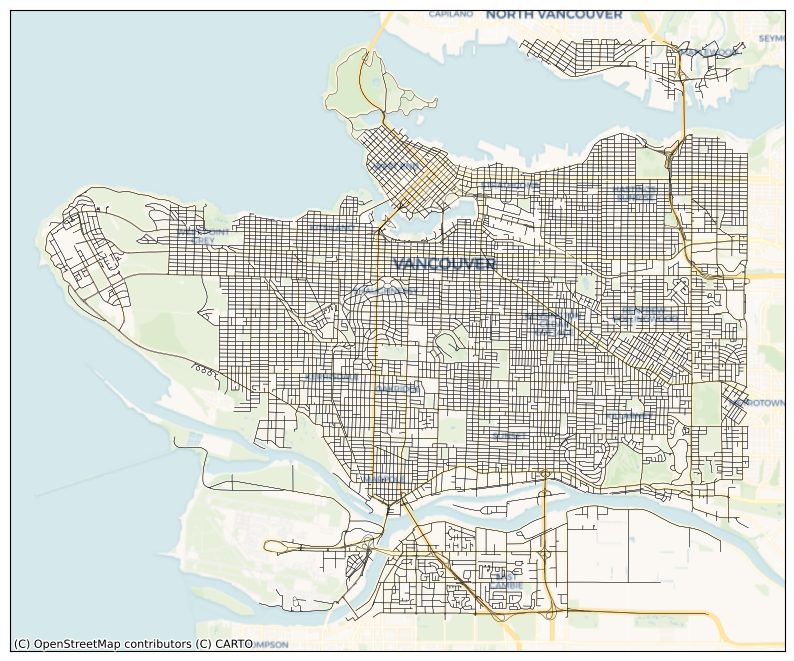

In [52]:
nodes, edges  = ox.graph_to_gdfs(G)

f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)

In [53]:
stores_downtown = [
    (49.291074726223876, -123.1345112715533),
    (49.285778717275015, -123.1388610469531),
    (49.28543824009544, -123.12140394834859),
    (49.288086333967435, -123.11403832867163),
    (49.28108749140217, -123.12134595134327),
    (49.27953626208601, -123.1155462508102),
    (49.28131449647768, -123.10713668503729)
]

stores_van = [
    (49.26710745424008, -123.24276573624313),
    (49.26495239140005, -123.17770621538237),
    (49.269395328423684, -123.15949483697254),
    (49.264310005956226, -123.13849432853601),
    (49.236563149786534, -123.1543967279795)
]

stores_eastvan = [
    (49.265501224782504, -123.1167840944718),  
    (49.264156985091404, -123.06992053669686),  
    (49.260348107095176, -123.04365634497684),  
    (49.26762952939976, -123.02494525414363),  
    (49.24711277560665, -123.10169652190295),  
    (49.24640207307076, -123.06359221703782),  
    (49.23452058476019, -123.06597739540537),  
    (49.207897379250966, -123.12469600383916),  
    (49.21458384969505, -123.10853491891567),  
    (49.22126941578986, -123.07746972234048),
    (49.272454228734645, -123.1004652050492),  
    (49.281730801002375, -123.03062404165448)
]

storage = [(49.19415257260286, -123.17518597496046)]

stores = storage + stores_downtown + stores_van + stores_eastvan
len(stores)

25

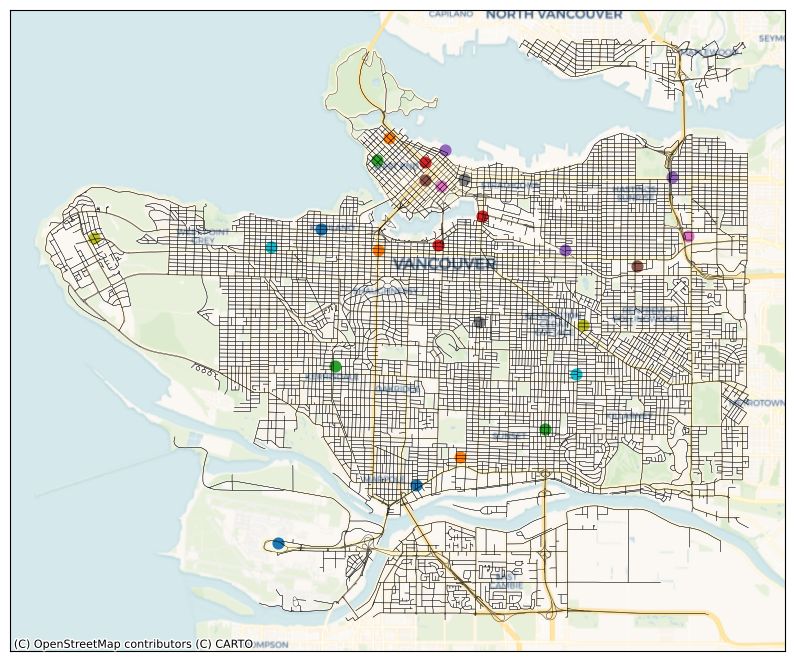

In [54]:
f,ax = plt.subplots(1,1, figsize=(10,12))
plot_graph(f,ax,edges)
for point in stores:
    latitude,longitude = point
    ax.scatter(longitude,latitude,s=60,label = point)
plt.show()

In [55]:
important_nodes = [ox.distance.nearest_nodes(G, point[1],point[0]) 
                   for point in stores]
G = ox.distance.add_edge_lengths(G)

In [56]:
shortest_paths = [[nx.shortest_path(G,node_0,node_1,weight='length') 
                   for node_1 in important_nodes] for node_0 in important_nodes]
shortest_path_lengths = np.array([
    [nx.shortest_path_length(G,node_0,node_1,weight='length') for node_1 in important_nodes]
    for node_0 in important_nodes
])

In [57]:
def get_path_edges(path_nodes,edges):
    edge_list = [(path_nodes[j],path_nodes[j+1]) for j in range(len(path_nodes)-1)]
    return edges[edges.index.isin(edge_list)]

def plot_paths(f,ax,tour,shortest_paths,lwidth):
    for i in range(len(tour)-1):
        shortest_path_edges = get_path_edges(shortest_paths[tour[i]][tour[i+1]],edges)
        shortest_path_edges.plot(linewidth=lwidth, ax=ax, color='b')
    shortest_path_edges = get_path_edges(shortest_paths[tour[-1]][tour[0]],edges)
    shortest_path_edges.plot(linewidth=lwidth, ax=ax, color='b')

def cost_matrix(V):
    n = V.shape[0]
    C = np.zeros((n,n))
    for i in range(1,n):
        for j in range(0,i):
            C[i,j] = np.sqrt((V[j,0] - V[i,0])**2 + (V[j,1] - V[i,1])**2)
            C[j,i] = C[i,j]
    return C

def tour_cost(C,tour):
    n = len(tour)
    cost = 0
    for i in range(n-1):
        cost += C[tour[i],tour[i+1]]
    cost += C[tour[-1],tour[0]]
    return cost

def nearest_neighbor(V,start=4, C = None):
    n = V.shape[0]
    if C is None:
        C = cost_matrix(V)
    tour = [start]
    nodes = list(range(n))
    nodes.remove(start)
    for i in range(1,n):
        next_i = np.argmin(C[tour[-1],nodes])
        next_node = nodes[next_i]
        tour.append(next_node)
        nodes.pop(next_i)
    cost = tour_cost(C,tour)
    return tour,cost

In [58]:
V = np.array(stores)

In [59]:
tour,cost = nearest_neighbor(V,start = 0, C=shortest_path_lengths)
tour_named = [stores[i] for i in tour]
tour_named

[(49.19415257260286, -123.17518597496046),
 (49.207897379250966, -123.12469600383916),
 (49.21458384969505, -123.10853491891567),
 (49.22126941578986, -123.07746972234048),
 (49.23452058476019, -123.06597739540537),
 (49.24640207307076, -123.06359221703782),
 (49.264156985091404, -123.06992053669686),
 (49.260348107095176, -123.04365634497684),
 (49.26762952939976, -123.02494525414363),
 (49.281730801002375, -123.03062404165448),
 (49.28131449647768, -123.10713668503729),
 (49.27953626208601, -123.1155462508102),
 (49.28108749140217, -123.12134595134327),
 (49.28543824009544, -123.12140394834859),
 (49.288086333967435, -123.11403832867163),
 (49.291074726223876, -123.1345112715533),
 (49.285778717275015, -123.1388610469531),
 (49.264310005956226, -123.13849432853601),
 (49.265501224782504, -123.1167840944718),
 (49.272454228734645, -123.1004652050492),
 (49.24711277560665, -123.10169652190295),
 (49.236563149786534, -123.1543967279795),
 (49.26495239140005, -123.17770621538237),
 (49.2

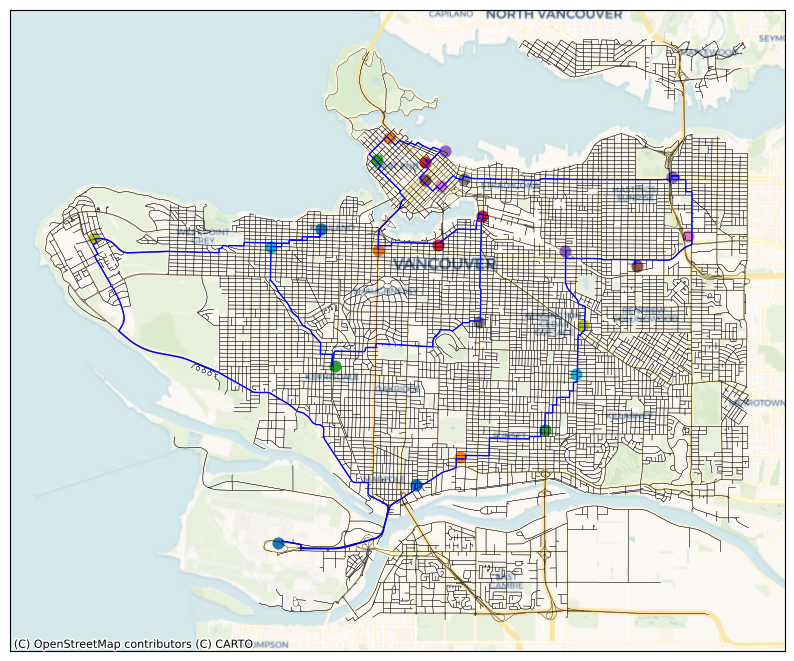

In [60]:
f,ax = plt.subplots(1,1, figsize=(10,10))
plot_graph(f,ax,edges)
for point in stores:
    ax.scatter(point[1],point[0],s=60)
plot_paths(f,ax,tour,shortest_paths,1)
plt.show()